In [30]:
# Import utility functions
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import requests
import json
sys.path.append('..')  # Add parent directory to path

# Import from local utility modules
from lvt_utils import (model_split_rate_tax, calculate_current_tax, ensure_geodataframe, 
                       categorize_property_type, calculate_category_tax_summary, print_category_tax_summary)
from census_utils import (get_census_data_with_boundaries, match_parcels_to_demographics, 
                          create_demographic_summary, calculate_median_percentage_by_quintile, match_to_census_blockgroups)
from viz import (create_scatter_plot, plot_comparison, calculate_correlations, weighted_median, 
                 create_quintile_summary, plot_quintile_analysis, create_property_category_chart, 
                 create_map_visualization, calculate_block_group_summary, filter_data_for_analysis)

# Control variable for data scraping
data_scrape = 1  # Set to 1 to scrape new data, 0 to use existing data

print("✅ Utility functions imported from LVTShift modules")


✅ Utility functions imported from LVTShift modules


In [31]:
import glob
from datetime import datetime

# Data directories
data_dir = "data/rochester/"
os.makedirs(data_dir, exist_ok=True)

# --- URLs for Rochester Open Data (ArcGIS REST) ---
PARCELS_URL = "https://maps.cityofrochester.gov/arcgis/rest/services/App_PropertyInformation/ROC_Parcel_Query_RPS_Merged/MapServer/0/query"
EXEMPTIONS_URL = "https://maps.cityofrochester.gov/arcgis/rest/services/App_PropertyInformation/ROC_Parcel_Query_RPS_Merged/MapServer/8/query"
TAXBILL_URL = "https://maps.cityofrochester.gov/arcgis/rest/services/App_PropertyInformation/ROC_Parcel_Query_RPS_Merged/MapServer/9/query"

def download_arcgis_layer(url, id_col=None, geo=True, max_records=10000):
    """
    Download an entire ArcGIS REST layer (table or geojson) in batches.
    """
    import pandas as pd
    import geopandas as gpd

    # First grab record count
    r = requests.get(url, params={"where":"1=1","returnCountOnly":"true","f":"json"})
    n_records = r.json()["count"]

    dfs = []
    for start in range(0, n_records, max_records):
        params = {
            "where": "1=1",
            "outFields": "*",
            "f": "geojson" if geo else "json",
            "resultOffset": start,
            "resultRecordCount": min(max_records, n_records - start),
            "returnGeometry": str(geo).lower()
        }
        resp = requests.get(url, params=params)
        if geo:
            gdf = gpd.GeoDataFrame.from_features(resp.json()["features"])
        else:
            records = resp.json()["features"] if "features" in resp.json() else []
            # ArcGIS tables return JSON with features > attributes
            attr = [rec["attributes"] for rec in records]
            gdf = pd.DataFrame(attr)
        dfs.append(gdf)
        print(f"Downloaded {(start+1)}–{start+params['resultRecordCount']} of {n_records}", end="\r")
    df = pd.concat(dfs, ignore_index=True)
    return df

if data_scrape == 1:
    print("🔄 Downloading fresh Rochester property data...")

    # Download parcels (GeoDataFrame)
    print("📥 Downloading parcels...")
    gdf = download_arcgis_layer(PARCELS_URL, geo=True)
    print(f"✅ Downloaded {len(gdf):,} Rochester parcels")

    # Download exemptions (DataFrame, join by SBL20 to PARCELID)
    print("📥 Downloading exemptions...")
    exemptions = download_arcgis_layer(EXEMPTIONS_URL, geo=False)
    # Clean and sum multiple records for the same SBL (if present)
    exemptions["ExemptionAmount"] = pd.to_numeric(exemptions["ExemptionAmount"], errors="coerce").fillna(0)
    exemptions_sum = exemptions.groupby("SBL20")["ExemptionAmount"].sum().reset_index()
    exemptions_sum.rename(columns={"ExemptionAmount":"total_exemptions"}, inplace=True)

    # Download tax bill info (DataFrame, join by SBL20 to PARCELID)
    print("📥 Downloading tax bill data...")
    taxbill = download_arcgis_layer(TAXBILL_URL, geo=False)
    # Take the most recent tax bill per parcel if multiple
    taxbill_latest = taxbill.sort_values(["SBL20", "YR_2023"], ascending=[True,False])
    taxbill_latest = taxbill_latest.groupby("SBL20").first().reset_index() # Only most recent bill per parcel

    # Join the auxiliary data to main parcels
    gdf = gdf.merge(exemptions_sum, left_on="PARCELID", right_on="SBL20", how="left")
    gdf = gdf.merge(taxbill_latest, left_on="PARCELID", right_on="SBL20", how="left", suffixes=("", "_bill"))
    gdf["total_exemptions"] = gdf["total_exemptions"].fillna(0)

    # Calculate land/improvement and property tax variables based on Rochester column names
    gdf["land_value"] = gdf["CURRENT_LAND_VALUE"]
    gdf["total_value"] = gdf["CURRENT_TOTAL_VALUE"]
    gdf["taxable_value"] = gdf["CURRENT_TAXABLE_VALUE"]

    # If available, use TrueTax from bill. Otherwise, estimate using mill rate
    # Using city's stated mill rate in 2023: 20.992 per $1000 (source: https://www.cityofrochester.gov/article.aspx?id=8589935801)
    # But we use observed tax first
    gdf["property_tax"] = gdf["TrueTax"]
    missing_tax = gdf["property_tax"].isna()
    gdf.loc[missing_tax, "property_tax"] = gdf.loc[missing_tax, "taxable_value"] * (19.74/1000)

    # Compute improvement value, basic split-rate logic (if you wish)
    gdf["improvement_value"] = gdf["total_value"] - gdf["land_value"]

    # Save parquet
    today_str = datetime.now().strftime("%Y%m%d")
    save_path = f"{data_dir}rochester_parcels_processed_{today_str}.parquet"
    gdf.to_parquet(save_path)
    print(f"💾 Saved processed data to {save_path}")

else:
    print("📂 Loading existing Rochester property data...")
    # Find all processed parquet files in the data_dir
    parquet_files = glob.glob(os.path.join(data_dir, "rochester_parcels_processed_*.parquet"))
    if not parquet_files:
        print("❌ No processed Rochester data files found in data/rochester/. Please set data_scrape = 1 to download fresh data.")
        raise FileNotFoundError("No processed Rochester data files found.")
    # Extract dates and find the most recent file
    def extract_date(f):
        try:
            return datetime.strptime(os.path.basename(f).split("_")[-1].replace(".parquet", ""), "%Y%m%d")
        except Exception:
            return datetime.min
    parquet_files_sorted = sorted(parquet_files, key=extract_date, reverse=True)
    most_recent_file = parquet_files_sorted[0]
    gdf = gpd.read_parquet(most_recent_file)
    print(f"✅ Loaded processed Rochester data from {most_recent_file}")

print(f"\n📊 Dataset Overview:")
print(f"Total parcels: {len(gdf):,}")
print(f"Columns: {len(gdf.columns)}")
if isinstance(gdf, gpd.GeoDataFrame):
    print(f"Geometry type: {gdf.geometry.geom_type.iloc[0]}")

# Display key statistics
total_current_revenue = gdf['property_tax'].sum()
print(f"\n💰 Current Tax System:")
print(f"Total annual revenue: ${total_current_revenue:,.2f}")
print(f"Mean property tax: ${gdf['property_tax'].mean():,.2f}")
print(f"Median property tax: ${gdf['property_tax'].median():.2f}")


🔄 Downloading fresh Rochester property data...
📥 Downloading parcels...
✅ Downloaded 64,762 Rochester parcels
📥 Downloading exemptions...
📥 Downloading tax bill data...
💾 Saved processed data to data/rochester/rochester_parcels_processed_20251105.parquet

📊 Dataset Overview:
Total parcels: 64,762
Columns: 89
Geometry type: Polygon

💰 Current Tax System:
Total annual revenue: $301,912,439.34
Mean property tax: $4,665.41
Median property tax: $2206.84


In [50]:
# Compare TrueTax to property_tax and the percent of times they are equal

# Both columns should exist, but handle missing TrueTax gracefully
if 'TrueTax' in gdf.columns and 'property_tax' in gdf.columns:
    # Compare values (allow for floating-point error, e.g., tolerance 0.01)
    tol = 0.01
    valid = gdf['TrueTax'].notna() & gdf['property_tax'].notna()
    # Absolute difference less than tol means "equal"
    equal_mask = (abs(gdf.loc[valid, 'TrueTax'] - gdf.loc[valid, 'property_tax']) < tol)
    percent_equal = 100 * equal_mask.sum() / valid.sum() if valid.sum() > 0 else float('nan')
    print(f"\n🔎 TrueTax vs property_tax comparison:")
    print(f"Number of parcels compared: {valid.sum():,}")
    print(f"Number of exact matches (within ${tol}): {equal_mask.sum():,}")
    print(f"Percent of parcels where TrueTax == property_tax: {percent_equal:.2f}%")
else:
    print("One or both columns ('TrueTax', 'property_tax') are missing from the GeoDataFrame.")




🔎 TrueTax vs property_tax comparison:
Number of parcels compared: 61,358
Number of exact matches (within $0.01): 61,358
Percent of parcels where TrueTax == property_tax: 100.00%


In [32]:
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython.display import display

display(gdf.head(5))


,geometry,OBJECTID,PARCELID,PRINTKEY,STREET_NUM,STREET_NAME,SITEADDRESS,CITY,ZIP5,CLASSCD,CLASSDSCRP,PROPERTYTYPE,OWNERNME1,PSTLADDRESS,PSTLCITY,LOT_FRONTAGE,LOT_DEPTH,STATEDAREA,CURRENT_LAND_VALUE,CURRENT_TOTAL_VALUE,CURRENT_TAXABLE_VALUE,TENTATIVE_LAND_VALUE,TENTATIVE_TOTAL_VALUE,TENTATIVE_TAXABLE_VALUE,SALE_DATE,SALE_PRICE,BOOK,PAGE,DEED_TYPE,VALID,RESCOM,SHAPEACRES,BISZONING,OWNERSHIPCODE,NORESUNITS,LOW_STREET_NUM,HIGH_STREET_NUM,GISEXTDATE,SHAPE.STArea(),SHAPE.STLength(),LOW_STREET_SORT,MultiSale,PARCEL_SOURCE,SBL20,total_exemptions,SBL20_bill,OBJECTID_bill,CurrentTax,Payment01,Payment02,Payment03,Payment04,AmountPaid01,AmountPaid02,AmountPaid03,AmountPaid04,PayDate01,PayDate02,PayDate03,PayDate04,InterestDue,TrueTax,TotalPaid,PrincipalDue,TotalDue,TotalInterestPaid,YR_2015,YR_2016,YR_2017,YR_2018,YR_2019,YR_2020,YR_2021,YR_2022,YR_2023,YR_2024,YR_2025,YR_2026,YR_2027,YR_2028,YR_2029,YR_2030,YR_2031,YR_2032,land_value,total_value,taxable_value,property_tax,improvement_value
0,"POLYGON ((-77.62248 43.26748, -77.62252 43.267...",1,04628000010010000000,046.28-1-1,790,Beach Ave,790 Beach Ave,ROCHESTER,14612,312,Residential with Improvements,Vacant Land,Revocable Trusts Of Eric G & Michele Harnischf...,796 Beach Ave,"Rochester, NY 14612",138.14,257.38,0.00,172500.0,185500.0,185500.0,172500.0,185500.0,185500.0,03/19/2019,1.0,12165,00290,B,,R,0.667827,R-1,W,0,790,790,1762322415000,5099.125201,308.893240,790.0,1,MCRPS,NaN,0.0,04628000010010000000,1.0,2702.20,1133.20,523.0,523.0,523.0,1133.20,523.0,523.0,523.0,070825,070825,070825,070825,0.0,2702.20,2702.20,0.0,0.0,0.00,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,172500.0,185500.0,185500.0,2702.20,13000.0
1,"POLYGON ((-77.62214 43.26731, -77.62216 43.267...",2,04628000010020000000,046.28-1-2,780,Beach Ave,780 Beach Ave,ROCHESTER,14612,210,1 Family Residential,Residential,Joyce A Palvino Income Trust Palvino John C,780 Beach Ave,"Rochester, NY 14612",148.00,245.95,0.00,185000.0,641600.0,641600.0,185000.0,641600.0,641600.0,07/15/2025,1.0,13118,715,Q,,R,0.834850,R-1,W,1,780,780,1762322415000,6374.363362,332.113551,780.0,0,MCRPS,04628000010020000000,53000.0,04628000010020000000,2.0,8206.91,2545.91,1887.0,1887.0,1887.0,2545.91,1887.0,1887.0,1887.0,071025,071025,071025,071025,0.0,8297.27,8206.91,0.0,0.0,0.00,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,185000.0,641600.0,641600.0,8297.27,456600.0
2,"POLYGON ((-77.62184 43.26715, -77.62186 43.267...",3,04628000010030000000,046.28-1-3,770,Beach Ave,770 Beach Ave,ROCHESTER,14612,210,1 Family Residential,Residential,Perotto L/U Philip Perotto L/U Dorothy,770 Beach Ave,"Rochester, NY 14612",71.40,228.32,0.38,88000.0,475000.0,475000.0,88000.0,475000.0,475000.0,03/31/2013,1.0,11245,00228,W,,R,0.396711,R-1,W,1,770,770,1762322415000,3029.009744,265.016705,770.0,0,MCRPS,04628000010030000000,99000.0,04628000010030000000,3.0,5771.80,1682.80,1363.0,1363.0,1363.0,1682.80,1363.0,1363.0,1363.0,070925,070925,070925,070925,0.0,6076.80,5771.80,0.0,0.0,0.00,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,88000.0,475000.0,475000.0,6076.80,387000.0
3,"POLYGON ((-77.62162 43.26704, -77.62164 43.267...",4,04628000010040000000,046.28-1-4,760,Beach Ave,760 Beach Ave,ROCHESTER,14612,210,1 Family Residential,Residential,Luce Jane,PO BOX 93,"Dansville, NY 14437",73.00,228.32,0.00,90500.0,325000.0,325000.0,90500.0,325000.0,325000.0,06/06/2001,1.0,09467,00167,W,,R,0.402188,R-1,W,1,760,760,1762322415000,3070.816332,263.019192,760.0,0,MCRPS,NaN,0.0,04628000010040000000,4.0,4559.02,1511.02,1016.0,1016.0,1016.0,1511.02,1016.0,1016.0,1016.0,081525,081525,081525,081525,0.0,4391.20,4559.02,0.0,0.0,15.11,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,90500.0,325000.0,325000.0,4391.20,234500.0
4,"POLYGON ((-77.62375 43.26671, -77.62375 43.266...",5,04628000010050040000,046.28-1-5.004,30,Seascape Dr,30 Seascape Dr,ROCHESTER,14612,21

In [33]:
# Describe CLASSDSCRP with counts, showing all rows
print("Distribution of CLASSDSCRP (property class descriptions):")
pd.set_option('display.max_rows', None)
classdscrp_counts = gdf['CLASSDSCRP'].value_counts(dropna=False)
display(classdscrp_counts)
pd.reset_option('display.max_rows')


Distribution of CLASSDSCRP (property class descriptions):


CLASSDSCRP
1 Family Residential                    41163
2 Family Residential                     9236
Residential, Vacant Land                 3687
Apartment                                1876
Parking Lot                              1421
3 Family Residential                     1172
Detached Row Building                     885
Commercial, Vacant                        596
Other Storage                             484
Manufacturer                              361
Single Use Small Building                 351
Religious                                 329
Converted Residential                     319
Office Building                           273
Multiple Residential                      270
Auto Body                                 260
Residential with Improvements             179
Industrial, Vacant                        175
Attached Row Building                      99
Railroad, Non-Ceiling                      91
Multi-Use Small Building                   88
School                 

In [36]:
# Map detailed CLASSDSCRP codes to a smaller set of ~10 broader property categories for Rochester

def aggregate_classdscrp(classdscrp):
    # Lower-case for more robust matching
    desc = str(classdscrp).strip().lower()
    # Single Family
    if "1 family" in desc or "single family" in desc:
        return "Single Family Residential"
    # Multifamily
    if "2 family" in desc or "3 family" in desc or "multiple residential" in desc or "apartment" in desc or "detached row" in desc or "attached row" in desc or "converted residential" in desc or "row building" in desc:
        return "Multifamily Residential"
    # Residential, Vacant Land
    if "vacant" in desc or "vacant land" in desc:
        return "Vacant/Unused Land"
    # Parking/Parking-related
    if "parking" in desc:
        return "Parking"
    # Commercial/Retail/Office
    if ("commercial" in desc or "retail" in desc or "supermarket" in desc or "mini-mart" in desc or "shopping center" in desc or "restaurant" in desc or "bar" in desc or "fast food" in desc or "office" in desc or "bank" in desc or "dealer" in desc or "warehouse" in desc or "service" in desc or "hotel" in desc or "motel" in desc or "lodge" in desc or "funeral" in desc or "store" in desc or "movie theater" in desc or "night club" in desc or "theater" in desc):
        return "Commercial / Retail / Office"
    # Industrial/Manufacturing/Storage/Utilities
    if ("manufacturer" in desc or "industrial" in desc or "factory" in desc or "mill" in desc or "lumber" in desc or "cold storage" in desc or "utilities" in desc or "electric" in desc or "pipeline" in desc or "substation" in desc or "terminal" in desc):
        return "Industrial / Utility"
    # Institutional (schools, colleges, libraries, municipal, health, benevolent, cultural, etc)
    if ("school" in desc or "college" in desc or "university" in desc or "library" in desc or "government" in desc or "police" in desc or "fire" in desc or "municipal" in desc or "hospital" in desc or "clinic" in desc or "health" in desc or "auditorium" in desc or "culture" in desc or "professional building" in desc or "special schools" in desc or "miscellaneous franchise" in desc or "diner" in desc or "spa" in desc):
        return "Institutional / Civic"
    # Religious/Charitable/Benevolent
    if ("religious" in desc or "benevolent" in desc or "ymca" in desc or "ywca" in desc or "home for the aged" in desc or "social organization" in desc or "animal welfare" in desc or "welfare" in desc or "cemetery" in desc or "church" in desc or "funeral" in desc):
        return "Religious / Charitable / Social"
    # Recreation/Park/Leisure/Cultural
    if ("park" in desc or "playground" in desc or "marina" in desc or "athletic" in desc or "field" in desc or "stadium" in desc or "recreational" in desc or "entertainment" in desc or "public park" in desc or "state park" in desc or "indoor sport" in desc or "indoor rink" in desc or "bowling" in desc or "picnic" in desc or "water district" in desc):
        return "Recreation / Park"
    # Transportation/Storage/Terminal
    if ("railroad" in desc or "transport" in desc or "terminal" in desc or "garage" in desc or "truck" in desc or "street" in desc or "highway" in desc or "lot" == desc):
        return "Transportation / Storage"
    # All others
    return "Other / Miscellaneous"

gdf['PROPERTY_CATEGORY'] = gdf['CLASSDSCRP'].apply(aggregate_classdscrp)

In [37]:
# Ensure proper GeoDataFrame format
gdf = ensure_geodataframe(gdf)

# Create vacant flag based on CLASSDSCRP containing "vacant" (case-insensitive)
gdf['is_vacant'] = gdf['CLASSDSCRP'].str.lower().str.contains("vacant")


# Display property statistics
print(f"🏠 Property Statistics:")
print(f"Total parcels: {len(gdf):,}")
print(f"Vacant parcels: {gdf['is_vacant'].sum():,} ({gdf['is_vacant'].sum()/len(gdf)*100:.1f}%)")

print("\n📋 Property Categories (Standardized):")
category_counts = gdf['PROPERTY_CATEGORY'].value_counts()
for category, count in category_counts.head(10).items():
    pct = count / len(gdf) * 100
    print(f"  {category}: {count:,} ({pct:.1f}%)")

print("\n🏗️ Property Value Statistics:")
print(f"Mean land value: ${gdf['land_value'].mean():,.2f}")
print(f"Mean improvement value: ${gdf['improvement_value'].mean():,.2f}")
print(f"Total land value: ${gdf['land_value'].sum():,.2f}")
print(f"Total improvement value: ${gdf['improvement_value'].sum():,.2f}")


🏠 Property Statistics:
Total parcels: 64,762
Vacant parcels: 4,498 (6.9%)

📋 Property Categories (Standardized):
  Single Family Residential: 41,163 (63.6%)
  Multifamily Residential: 13,857 (21.4%)
  Vacant/Unused Land: 4,498 (6.9%)
  Other / Miscellaneous: 1,573 (2.4%)
  Parking: 1,459 (2.3%)
  Commercial / Retail / Office: 708 (1.1%)
  Industrial / Utility: 504 (0.8%)
  Religious / Charitable / Social: 412 (0.6%)
  Institutional / Civic: 328 (0.5%)
  Transportation / Storage: 143 (0.2%)

🏗️ Property Value Statistics:
Mean land value: $17,771.58
Mean improvement value: $217,128.16
Total land value: $1,150,052,061.00
Total improvement value: $14,051,014,607.00


In [38]:
print("gdf columns:", list(gdf.columns))

# Calculate current property tax using LVTShift utility
# Use 'Fvalue' as the tax value column and a fixed millage rate for all properties

# Set the citywide millage rate (9.2645 per $1,000 of value)
gdf['millage_rate'] = 19.74
gdf['exemptions'] = gdf['CURRENT_TOTAL_VALUE'] - gdf['CURRENT_TAXABLE_VALUE']
gdf['improvement_value'] = gdf['CURRENT_TOTAL_VALUE'] - gdf['CURRENT_LAND_VALUE']
# Now use the utility to calculate current tax
from lvt_utils import calculate_current_tax

total_revenue, second_revenue, gdf = calculate_current_tax(
    df=gdf,
    tax_value_col='CURRENT_TOTAL_VALUE',
    millage_rate_col='millage_rate',
    exemption_col='exemptions'
)

print(f"Calculated total current tax revenue: ${total_revenue:,.2f}")



gdf columns: ['geometry', 'OBJECTID', 'PARCELID', 'PRINTKEY', 'STREET_NUM', 'STREET_NAME', 'SITEADDRESS', 'CITY', 'ZIP5', 'CLASSCD', 'CLASSDSCRP', 'PROPERTYTYPE', 'OWNERNME1', 'PSTLADDRESS', 'PSTLCITY', 'LOT_FRONTAGE', 'LOT_DEPTH', 'STATEDAREA', 'CURRENT_LAND_VALUE', 'CURRENT_TOTAL_VALUE', 'CURRENT_TAXABLE_VALUE', 'TENTATIVE_LAND_VALUE', 'TENTATIVE_TOTAL_VALUE', 'TENTATIVE_TAXABLE_VALUE', 'SALE_DATE', 'SALE_PRICE', 'BOOK', 'PAGE', 'DEED_TYPE', 'VALID', 'RESCOM', 'SHAPEACRES', 'BISZONING', 'OWNERSHIPCODE', 'NORESUNITS', 'LOW_STREET_NUM', 'HIGH_STREET_NUM', 'GISEXTDATE', 'SHAPE.STArea()', 'SHAPE.STLength()', 'LOW_STREET_SORT', 'MultiSale', 'PARCEL_SOURCE', 'SBL20', 'total_exemptions', 'SBL20_bill', 'OBJECTID_bill', 'CurrentTax', 'Payment01', 'Payment02', 'Payment03', 'Payment04', 'AmountPaid01', 'AmountPaid02', 'AmountPaid03', 'AmountPaid04', 'PayDate01', 'PayDate02', 'PayDate03', 'PayDate04', 'InterestDue', 'TrueTax', 'TotalPaid', 'PrincipalDue', 'TotalDue', 'TotalInterestPaid', 'YR_201

In [39]:
# Prepare data for LVTShift modeling (if not already done during data scraping)
print("🔧 Preparing data for 4:1 split-rate tax modeling...")

print("📊 Running 4:1 split-rate tax calculations...")

# Use LVTShift model_split_rate_tax function with exemptions
land_rate, building_rate, actual_revenue, results_df = model_split_rate_tax(
    df=gdf,
    land_value_col='CURRENT_LAND_VALUE',
    improvement_value_col='improvement_value', 
    current_revenue=total_current_revenue,
    land_improvement_ratio=10,  # 4:1 ratio
    exemption_col='exemptions'  # Include exemptions in the calculation
)

# Copy results back to main dataframe
gdf['new_tax'] = results_df['new_tax']
gdf['tax_change'] = results_df['tax_change']
gdf['tax_change_pct'] = results_df['tax_change_pct']

print(f"✅ Split-rate calculations completed using LVTShift tools")
print(f"   Land rate: ${land_rate*1000:.3f} per $1,000")
print(f"   Building rate: ${building_rate*1000:.3f} per $1,000")
print(f"   Revenue accuracy: {actual_revenue/total_current_revenue*100:.4f}%")



🔧 Preparing data for 4:1 split-rate tax modeling...
📊 Running 4:1 split-rate tax calculations...
Split-rate tax model (Land:Improvement = 10:1)
Land millage rate: 118.1582
Improvement millage rate: 11.8158
Total tax revenue: $301,912,439.34
Target revenue: $301,912,439.34
Revenue difference: $0.00 (0.0000%)

Split-Rate Tax Change by Property Category
                       Category  Count Total Tax Change ($) Total Change (%) Mean Change ($) Median Change ($) Avg % Change Median % Change % Parcels > +10% % Parcels < -10%
      Single Family Residential  41163          $-6,820,017            -5.7%           $-166              $-85        -0.9%           -3.8%            20.5%            32.4%
        Multifamily Residential  13857          $-5,433,050            -7.4%           $-392             $-128         1.0%           -5.5%            22.6%            38.0%
             Vacant/Unused Land   4498           $4,993,791           461.4%          $1,110              $595       492.9%  

In [40]:
import pandas as pd
pd.set_option('display.max_columns', None)
display(gdf.head())

,geometry,OBJECTID,PARCELID,PRINTKEY,STREET_NUM,STREET_NAME,SITEADDRESS,CITY,ZIP5,CLASSCD,CLASSDSCRP,PROPERTYTYPE,OWNERNME1,PSTLADDRESS,PSTLCITY,LOT_FRONTAGE,LOT_DEPTH,STATEDAREA,CURRENT_LAND_VALUE,CURRENT_TOTAL_VALUE,CURRENT_TAXABLE_VALUE,TENTATIVE_LAND_VALUE,TENTATIVE_TOTAL_VALUE,TENTATIVE_TAXABLE_VALUE,SALE_DATE,SALE_PRICE,BOOK,PAGE,DEED_TYPE,VALID,RESCOM,SHAPEACRES,BISZONING,OWNERSHIPCODE,NORESUNITS,LOW_STREET_NUM,HIGH_STREET_NUM,GISEXTDATE,SHAPE.STArea(),SHAPE.STLength(),LOW_STREET_SORT,MultiSale,PARCEL_SOURCE,SBL20,total_exemptions,SBL20_bill,OBJECTID_bill,CurrentTax,Payment01,Payment02,Payment03,Payment04,AmountPaid01,AmountPaid02,AmountPaid03,AmountPaid04,PayDate01,PayDate02,PayDate03,PayDate04,InterestDue,TrueTax,TotalPaid,PrincipalDue,TotalDue,TotalInterestPaid,YR_2015,YR_2016,YR_2017,YR_2018,YR_2019,YR_2020,YR_2021,YR_2022,YR_2023,YR_2024,YR_2025,YR_2026,YR_2027,YR_2028,YR_2029,YR_2030,YR_2031,YR_2032,land_value,total_value,taxable_value,property_tax,improvement_value,is_vacant,PROPERTY_CATEGORY,millage_rate,exemptions,current_tax,new_tax,tax_change,tax_change_pct
0,"POLYGON ((-77.62248 43.26748, -77.62252 43.267...",1,04628000010010000000,046.28-1-1,790,Beach Ave,790 Beach Ave,ROCHESTER,14612,312,Residential with Improvements,Vacant Land,Revocable Trusts Of Eric G & Michele Harnischf...,796 Beach Ave,"Rochester, NY 14612",138.14,257.38,0.00,172500.0,185500.0,185500.0,172500.0,185500.0,185500.0,03/19/2019,1.0,12165,00290,B,,R,0.667827,R-1,W,0,790,790,1762322415000,5099.125201,308.893240,790.0,1,MCRPS,NaN,0.0,04628000010010000000,1.0,2702.20,1133.20,523.0,523.0,523.0,1133.20,523.0,523.0,523.0,070825,070825,070825,070825,0.0,2702.20,2702.20,0.0,0.0,0.00,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,172500.0,185500.0,185500.0,2702.20,13000.0,False,Other / Miscellaneous,19.74,0.0,3661.770,20535.901860,16874.131860,460.818999
1,"POLYGON ((-77.62214 43.26731, -77.62216 43.267...",2,04628000010020000000,046.28-1-2,780,Beach Ave,780 Beach Ave,ROCHESTER,14612,210,1 Family Residential,Residential,Joyce A Palvino Income Trust Palvino John C,780 Beach Ave,"Rochester, NY 14612",148.00,245.95,0.00,185000.0,641600.0,641600.0,185000.0,641600.0,641600.0,07/15/2025,1.0,13118,715,Q,,R,0.834850,R-1,W,1,780,780,1762322415000,6374.363362,332.113551,780.0,0,MCRPS,04628000010020000000,53000.0,04628000010020000000,2.0,8206.91,2545.91,1887.0,1887.0,1887.0,2545.91,1887.0,1887.0,1887.0,071025,071025,071025,071025,0.0,8297.27,8206.91,0.0,0.0,0.00,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,185000.0,641600.0,641600.0,8297.27,456600.0,False,Single Family Residential,19.74,0.0,12665.184,27254.379303,14589.195303,115.191341
2,"POLYGON ((-77.62184 43.26715, -77.62186 43.267...",3,04628000010030000000,046.28-1-3,770,Beach Ave,770 Beach Ave,ROCHESTER,14612,210,1 Family Residential,Residential,Perotto L/U Philip Perotto L/U Dorothy,770 Beach Ave,"Rochester, NY 14612",71.40,228.32,0.38,88000.0,475000.0,475000.0,88000.0,475000.0,475000.0,03/31/2013,1.0,11245,00228,W,,R,0.396711,R-1,W,1,770,770,1762322415000,3029.009744,265.016705,770.0,0,MCRPS,04628000010030000000,99000.0,04628000010030000000,3.0,5771.80,1682.80,1363.0,1363.0,1363.0,1682.80,1363.0,1363.0,1363.0,070925,070925,070925,070925,0.0,6076.80,5771.80,0.0,0.0,0.00,None,None,None,None,None,Yes,Yes,Yes,Yes,Yes,Yes,Yes,None,None,None,None,None,None,88000.0,475000.0,475000.0,6076.80,387000.0,False,Single Family Residential,19.74,0.0,9376.500,14970.648824,5594.148824,59.661375
3,"POLYGON ((-77.62162 43.26704, -77.62164 43.267...",4,04628000010040000000,046.28-1-4,760,Beach Ave,760 Beach Ave,ROCHESTER,14612,210,1 Family Residential,Residential,Luce Jane,PO BOX 93,"Dansville, NY 14437",73.00,228.32,0.00,90500.0,325000.0,325000.0,90500.0,325000.0,325000.0,06/06/2001,1.0,09467,00167,W,,R,0.402188,R-1,W,1,760,760,1762322415000,3070.816332,263.019192,760.0,0,MCRPS,NaN,0.0,04628000010040000000,4.0,4559.02,1511.02,1016.0,1016.0,1016.0,

In [41]:
# Calculate comprehensive tax impact summary by property category
category_summary = calculate_category_tax_summary(
    df=gdf,
    category_col='PROPERTY_CATEGORY',
    current_tax_col='current_tax',
    new_tax_col='new_tax',
    pct_threshold=10.0
)

# Print formatted summary
print_category_tax_summary(
    summary_df=category_summary,
    title="4:1 Split-Rate Tax Impact by Property Category - Syracuse, NY",
    pct_threshold=10.0
)

# Display the detailed summary table
display(category_summary)



4:1 Split-Rate Tax Impact by Property Category - Syracuse, NY
                       Category  Count Total Tax Change ($) Total Change (%) Mean Change ($) Median Change ($) Avg % Change Median % Change % Parcels > +10% % Parcels < -10%
      Single Family Residential  41163          $-6,820,017            -5.7%           $-166              $-85        -0.9%           -3.8%            20.5%            32.4%
        Multifamily Residential  13857          $-5,433,050            -7.4%           $-392             $-128         1.0%           -5.5%            22.6%            38.0%
             Vacant/Unused Land   4498           $4,993,791           461.4%          $1,110              $595       492.9%          498.6%            99.6%             0.1%
          Other / Miscellaneous   1573           $3,413,695            33.4%          $2,170            $1,149       105.3%           63.7%            79.7%             7.1%
                        Parking   1459           $5,735,917        

,PROPERTY_CATEGORY,total_tax_change_dollars,property_count,mean_tax_change,median_tax_change,mean_tax_change_pct,median_tax_change_pct,total_current_tax,total_new_tax,pct_increase_gt_threshold,pct_decrease_gt_threshold,total_tax_change_pct
8,Single Family Residential,-6.820017e+06,41163,-165.683175,-85.074224,-0.856642,-3.835871,1.199066e+08,1.130866e+08,20.462551,32.412604,-5.687774
3,Multifamily Residential,-5.433050e+06,13857,-392.079841,-128.292572,1.012994,-5.484125,7.374692e+07,6.831387e+07,22.551779,37.973587,-7.367155
10,Vacant/Unused Land,4.993791e+06,4498,1110.224688,595.430343,492.875417,498.572637,1.082342e+06,6.076132e+06,99.555358,0.111161,461.387567
4,Other / Miscellaneous,3.413695e+06,1573,2170.181013,1149.020715,105.305682,63.727221,1.022217e+07,1.363587e+07,79.656707,7.120153,33.394994
5,Parking,5.735917e+06,1459,3931.403137,1350.120723,401.391231,415.109692,3.194906e+06,8.930823e+06,99.108979,0.548321,179.533208
0,Commercial / Retail / Office,2.417349e+06,708,3414.334595,1983.840478,51.930039,31.285260,1.693509e+07,1.935243e+07,67.655367,13.700565,14.274205
1,Industrial / Utility,-9.908793e+06,504,-19660.303742,1838.597742,102.843352,43.163076,4.078252e+07,3.087373e+07,71.230159,15.873016,-24.296667
7,Religious / Charitable / Social,2.045838e+06,412,4965.627334,1642.910788,68.400812,36.231361,5.174318e+06,7.220156e+06,72.087379,10.194175,39.538322
2,Institutional / Civic,-4.419642e+05,328,-1347.451941,2907.648696,110.330249,34.498813,2.408852e+07,2.364656e+07,65.243902,19.817073,-1.834750
9,Transportation / Storage,3.944045e+06,143,27580.735667,49.209119,192.456097,94.536107,2.785787e+06,6.729832e+06,57.342657,41.258741,141.577415


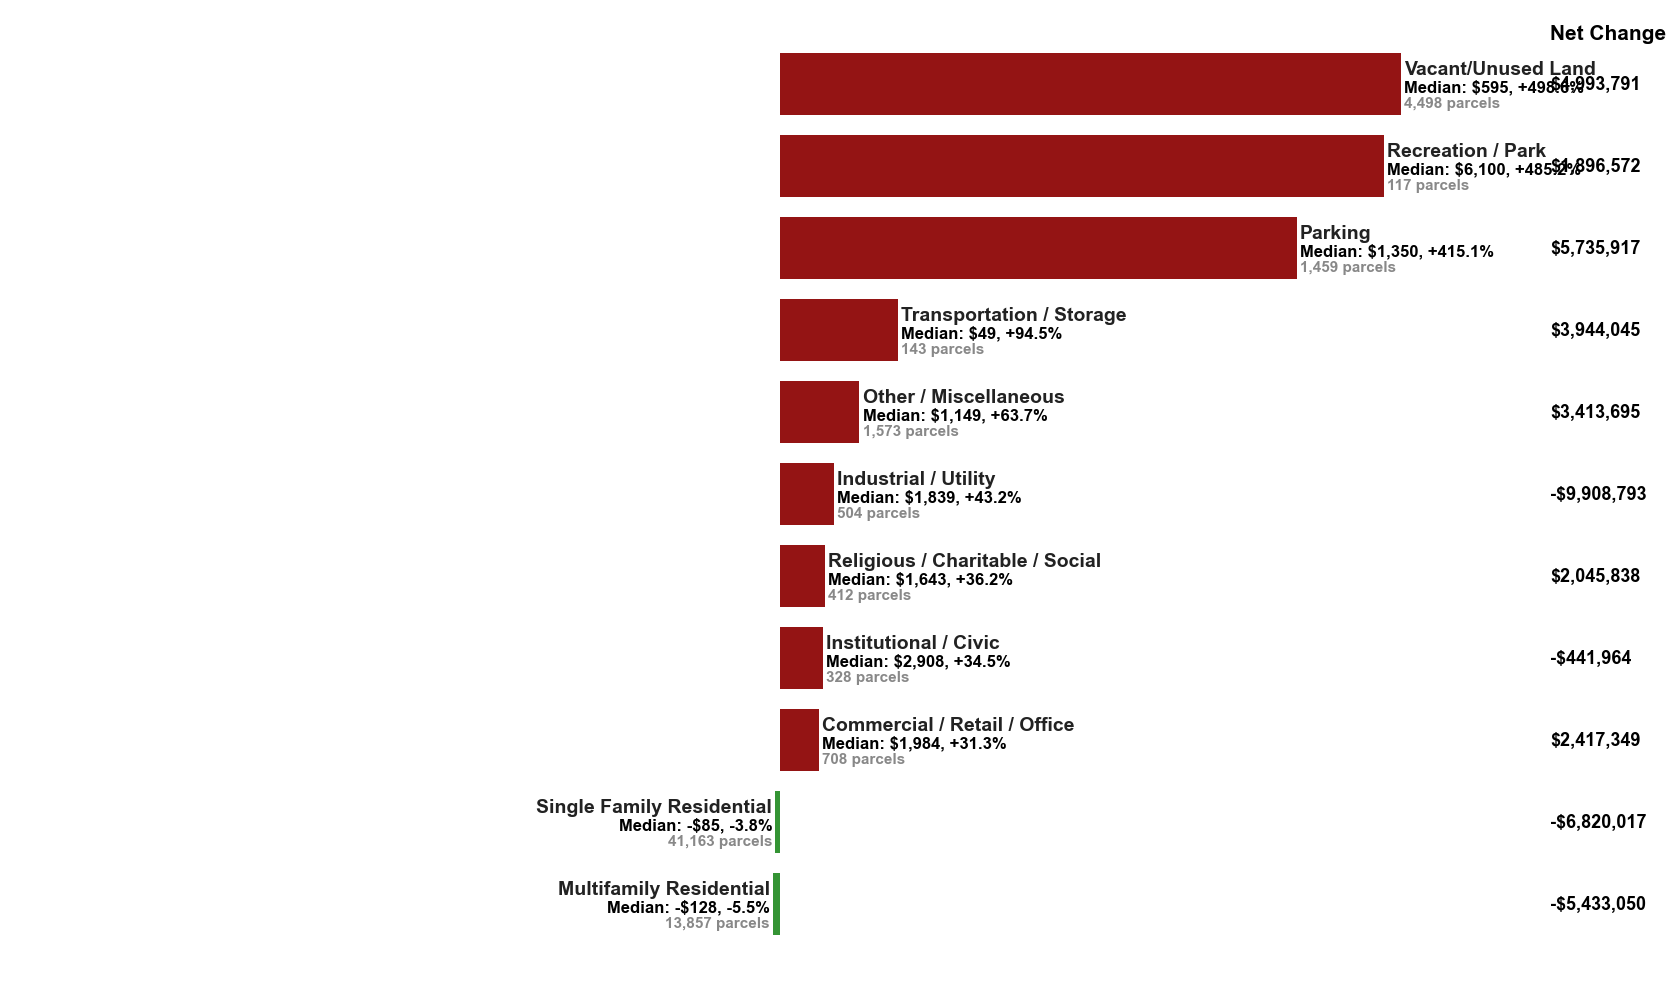

In [42]:
# Property category impact chart (Spokane style, sorted, ignore 0% median)
import matplotlib.pyplot as plt
import numpy as np

# Filter out categories where median tax change percent is exactly 0
filtered = category_summary[category_summary['median_tax_change_pct'] != 0].copy()

# Only include categories with property_count > 0 (optional, but safe)
filtered = filtered[filtered['property_count'] > 0]

# Sort by median_pct_change ascending (like Spokane)
categories = filtered['PROPERTY_CATEGORY'].tolist()
counts = filtered['property_count'].tolist()
median_pct_change = filtered['median_tax_change_pct'].tolist()
median_dollar_change = filtered['median_tax_change'].tolist()
total_tax_change = (
    filtered['total_tax_change_dollars'].tolist()
    if 'total_tax_change_dollars' in filtered.columns
    else (filtered['mean_tax_change'] * filtered['property_count']).tolist()
)

# Sort by median_pct_change ascending
sorted_idx = np.argsort(median_pct_change)
categories = [categories[i] for i in sorted_idx]
counts = [counts[i] for i in sorted_idx]
median_pct_change = [median_pct_change[i] for i in sorted_idx]
median_dollar_change = [median_dollar_change[i] for i in sorted_idx]
total_tax_change = [total_tax_change[i] for i in sorted_idx]

# Custom color: anything above 0 is dark red, below 0 is green
bar_colors = []
for val in median_pct_change:
    if val > 0:
        bar_colors.append("#8B0000")  # dark red
    else:
        bar_colors.append("#228B22")  # professional green

# Bar settings
bar_height = 0.75
fig_height = len(categories) * 0.8 + 1.2
right_col_pad = 120  # more padding for right column
fig, ax = plt.subplots(figsize=(17, fig_height))  # wider for right column

y = np.arange(len(categories))

# Draw bars
ax.barh(
    y, median_pct_change, color=bar_colors, edgecolor='none',
    height=bar_height, alpha=0.92, linewidth=0, zorder=2
)

# Remove all spines and ticks for a clean look
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Adjusted vertical spacing
cat_offset = 0.18   # less space between category and median
med_offset = -0.03  # median just below category
count_offset = -0.23  # more space below median for parcels

# For right column: position for total tax change
max_abs = max(abs(min(median_pct_change)), abs(max(median_pct_change)))
right_col_x = max_abs + right_col_pad

# Add Net Change header at the top of the right column
ax.text(
    right_col_x, len(categories) - 0.5, "Net Change", va='bottom', ha='left',
    fontsize=15, fontweight='bold', color='black', fontname='Arial'
)

for i, (cat, val, count, med_dol, tot_change) in enumerate(zip(categories, median_pct_change, counts, median_dollar_change, total_tax_change)):
    # Format median dollar and percent change together
    if med_dol >= 0:
        med_dol_str = f"${med_dol:,.0f}"
    else:
        med_dol_str = f"-${abs(med_dol):,.0f}"
    pct_str = f"{val:+.1f}%"
    median_combo = f"Median: {med_dol_str}, {pct_str}"

    # Position: right of bar for positive, left for negative
    if val < 0:
        xpos = val - 2.5
        ha = 'right'
    else:
        xpos = val + 2.5
        ha = 'left'
    # Category name (bold, bigger)
    ax.text(
        xpos, y[i]+cat_offset, cat, va='center', ha=ha,
        fontsize=14, fontweight='bold', color='#222',
        fontname='Arial'
    )
    # Median (dollar + percent, bold, black, just below category)
    ax.text(
        xpos, y[i]+med_offset, median_combo, va='center', ha=ha,
        fontsize=12, fontweight='bold', color='black',
        fontname='Arial'
    )
    # Count (bold, smaller, below median)
    ax.text(
        xpos, y[i]+count_offset, f"{count:,} parcels", va='center', ha=ha,
        fontsize=11, fontweight='bold', color='#888',
        fontname='Arial'
    )
    # Net change column, always right-aligned in a new column, black text, no "Total:"
    if tot_change >= 0:
        tot_change_str = f"${tot_change:,.0f}"
    else:
        tot_change_str = f"-${abs(tot_change):,.0f}"
    ax.text(
        right_col_x, y[i], tot_change_str, va='center', ha='left',
        fontsize=13, fontweight='bold', color='black',
        fontname='Arial'
    )

# Set x limits for symmetry, make bars longer, and leave space for right column
ax.set_xlim(-right_col_x, right_col_x + 60)

# Remove axis labels/ticks
ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()
plt.show()


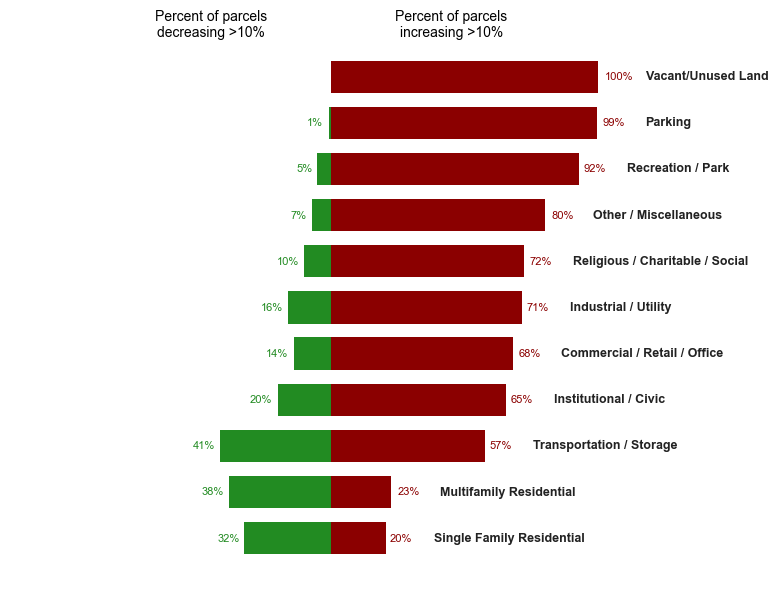

In [52]:
import matplotlib.pyplot as plt
import numpy as np
output_summary = category_summary
# Summarize output by PROPERTY_CATEGORY, using the output_summary DataFrame (as in Spokane)
summary_filtered = output_summary[output_summary['property_count'] > 50].copy()
summary_sorted = summary_filtered.sort_values('pct_increase_gt_threshold', ascending=True)

categories_sorted = summary_sorted['PROPERTY_CATEGORY'].tolist()
pct_increase_sorted = summary_sorted['pct_increase_gt_threshold'].tolist()
pct_decrease_sorted = summary_sorted['pct_decrease_gt_threshold'].tolist()

# Convert to integers for display
pct_increase_int_sorted = [int(round(x)) for x in pct_increase_sorted]
pct_decrease_int_sorted = [int(round(x)) for x in pct_decrease_sorted]

y = np.arange(len(categories_sorted))

fig, ax = plt.subplots(figsize=(8, 6))

color_increase = "#8B0000"
color_decrease = "#228B22"

# Plot decreases (green, left)
ax.barh(
    y, 
    [-v for v in pct_decrease_sorted], 
    color=color_decrease, 
    edgecolor='none', 
    height=0.7
)
# Plot increases (red, right)
ax.barh(
    y, 
    pct_increase_sorted, 
    color=color_increase, 
    edgecolor='none', 
    height=0.7
)

# Add percent labels
for i, (inc, dec) in enumerate(zip(pct_increase_int_sorted, pct_decrease_int_sorted)):
    if dec > 0:
        ax.text(
            -dec - 2, y[i], f"{dec}%", 
            va='center', ha='right', 
            fontsize=8, fontweight='normal', color=color_decrease, fontname='Arial'
        )
    if inc > 0:
        ax.text(
            inc + 2, y[i], f"{inc}%", 
            va='center', ha='left', 
            fontsize=8, fontweight='normal', color=color_increase, fontname='Arial'
        )

# Add category label, right of increase bar
for i, (cat, inc) in enumerate(zip(categories_sorted, pct_increase_sorted)):
    xpos = inc + 18 if inc > 0 else 18
    ax.text(
        xpos, y[i], cat, 
        va='center', ha='left', 
        fontsize=9, fontweight='bold', color='#222', fontname='Arial'
    )

# Minimalist: remove all spines, ticks, axis lines
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('')

# Symmetrize
max_val = max(max(pct_increase_sorted), max(pct_decrease_sorted))
ax.set_xlim(-max_val-20, max_val+48)

# Custom titles
title_fontsize = 10
title_color = 'black'
title_fontweight = 'normal'
title_fontname = 'Arial'
title_y = len(categories_sorted) - 0.2

left_title_x = -max_val * 0.45
ax.text(
    left_title_x, title_y, 
    "Percent of parcels\ndecreasing >10%", 
    ha='center', va='bottom', fontsize=title_fontsize, fontweight=title_fontweight, 
    color=title_color, fontname=title_fontname, 
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15')
)
right_title_x = max_val * 0.45
ax.text(
    right_title_x, title_y, 
    "Percent of parcels\nincreasing >10%", 
    ha='center', va='bottom', fontsize=title_fontsize, fontweight=title_fontweight, 
    color=title_color, fontname=title_fontname, 
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15')
)

plt.tight_layout()
plt.show()


# census

In [45]:
# Get census data for Monroe County, NY (Rochester) - FIPS code: 36055
print("📊 Loading Census data for Monroe County, NY...")
df  = gdf
try:
    census_data, census_boundaries = get_census_data_with_boundaries(
        fips_code="36055",  # Monroe County, NY
        year=2022
    )
    print("GOT CENSUS DATA")
    # Set CRS for census boundaries before merging
    census_boundaries = census_boundaries.set_crs(epsg=4326)  # Assuming WGS84 coordinate system

    # Ensure our parcel data is in the same CRS
    if df.crs != census_boundaries.crs:
        df = df.to_crs(census_boundaries.crs)

    # Merge census data with our parcel boundaries
    df = match_to_census_blockgroups(
        gdf=df,
        census_gdf=census_boundaries
    )

    print(f"✅ Census data integration complete!")
    print(f"Number of census block groups: {len(census_boundaries)}")
    print(f"Number of census data records: {len(census_data)}")
    print(f"Number of parcels with census data: {len(df)}")

    # Display new columns added
    census_cols = [col for col in df.columns if col in ['median_income', 'minority_pct', 'black_pct', 'total_pop', 'census_block_group']]
    print(f"Census columns added: {census_cols}")

except Exception as e:
    print(f"❌ Error loading census data: {e}")


📊 Loading Census data for Monroe County, NY...
GOT CENSUS DATA
✅ Census data integration complete!
Number of census block groups: 10063
Number of census data records: 597
Number of parcels with census data: 64762
Census columns added: ['median_income', 'total_pop', 'census_block_group', 'minority_pct', 'black_pct']


📊 Analyzing tax impacts by neighborhood income quintiles (Residential parcels only)...
✅ Income quintile analysis complete (Residential only)
Residential parcels with income data: 49,877 (90.7% of residential)


/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_23971/3373369844.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_summary = df_with_income.groupby('income_quintile').agg({


,income_quintile,tax_change_count,tax_change_mean,tax_change_median,tax_change_pct_mean,tax_change_pct_median,median_income_mean,current_tax_mean
0,Q1 (Lowest),10206,-45.15,31.81,6.30,2.09,24003.45,2424.72
1,Q2,9819,-11.45,28.81,4.88,1.58,36294.86,2596.17
2,Q3,9989,-221.86,-124.87,-1.24,-4.74,46697.02,3677.39
3,Q4,10065,-247.70,-196.82,-4.02,-6.87,61137.97,3776.36
4,Q5 (Highest),9798,-635.12,-530.41,-9.32,-13.04,91831.29,5344.92


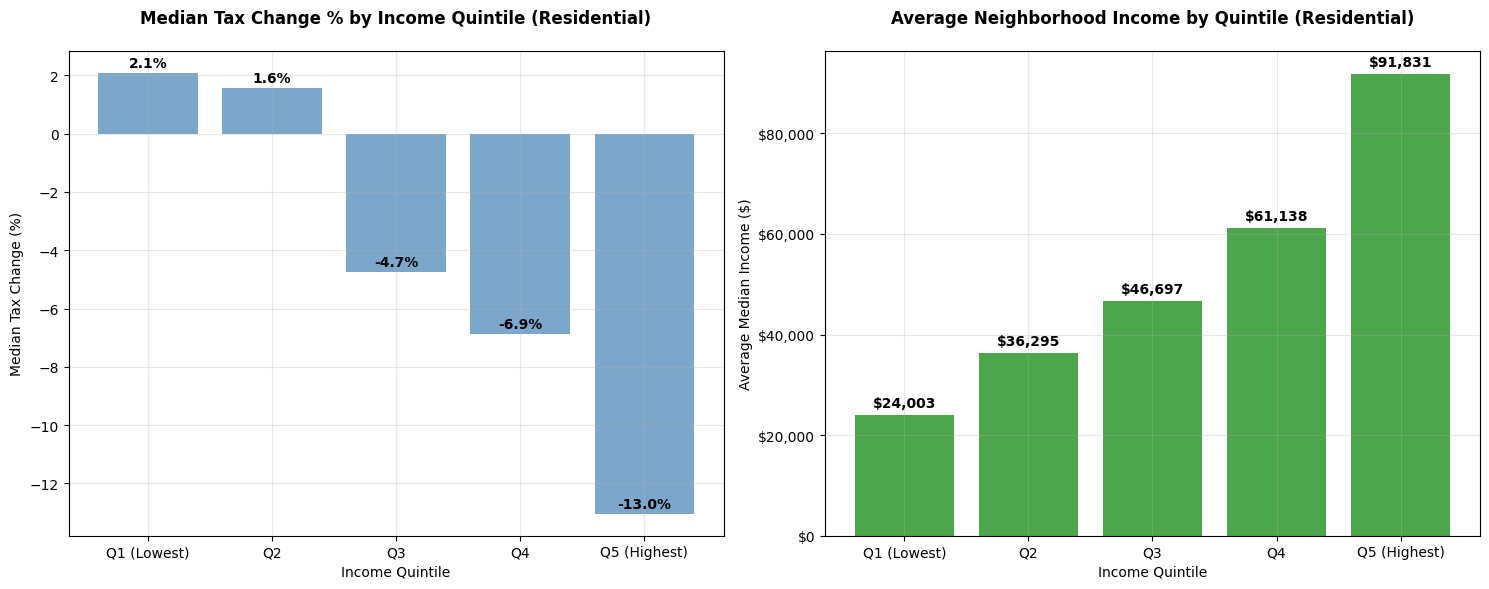

In [49]:
# Analyze tax impacts by income quintiles (similar to Spokane analysis), residential property only
print("📊 Analyzing tax impacts by neighborhood income quintiles (Residential parcels only)...")

if 'median_income' in df.columns:
    # Filter to only rows where property_category contains 'residential' (case-insensitive)
    df_residential = df[
        df['PROPERTY_CATEGORY'].str.contains('residential', case=False, na=False)
    ].copy()
    
    # Filter out parcels with missing or non-positive income data
    df_with_income = df_residential[(df_residential['median_income'].notna()) & (df_residential['median_income'] > 0)].copy()
    
    # Create income quintiles
    df_with_income['income_quintile'] = pd.qcut(
        df_with_income['median_income'], 
        5, 
        labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"]
    )
    
    # Calculate summary statistics by quintile
    quintile_summary = df_with_income.groupby('income_quintile').agg({
        'tax_change': ['count', 'mean', 'median'],
        'tax_change_pct': ['mean', 'median'],
        'median_income': 'mean',
        'current_tax': 'mean'
    }).round(2)
    
    # Flatten column names
    quintile_summary.columns = ['_'.join(col).strip() for col in quintile_summary.columns]
    quintile_summary = quintile_summary.reset_index()
    
    print(f"✅ Income quintile analysis complete (Residential only)")
    print(f"Residential parcels with income data: {len(df_with_income):,} ({len(df_with_income)/len(df_residential)*100:.1f}% of residential)")
    
    display(quintile_summary)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Median tax change percentage by income quintile
    quintile_data = quintile_summary.copy()
    quintile_data['median_tax_change_pct'] = quintile_data['tax_change_pct_median']
    
    bars1 = ax1.bar(
        quintile_data['income_quintile'],
        quintile_data['median_tax_change_pct'],
        color='steelblue',
        alpha=0.7
    )
    
    ax1.set_title('Median Tax Change % by Income Quintile (Residential)', fontweight='bold', pad=20)
    ax1.set_ylabel('Median Tax Change (%)')
    ax1.set_xlabel('Income Quintile')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, val in zip(bars1, quintile_data['median_tax_change_pct']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Average neighborhood income by quintile
    bars2 = ax2.bar(
        quintile_data['income_quintile'],
        quintile_data['median_income_mean'],
        color='green',
        alpha=0.7
    )
    
    ax2.set_title('Average Neighborhood Income by Quintile (Residential)', fontweight='bold', pad=20)
    ax2.set_ylabel('Average Median Income ($)')
    ax2.set_xlabel('Income Quintile')
    ax2.grid(True, alpha=0.3)
    
    # Format y-axis as currency
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add value labels on bars
    for bar, val in zip(bars2, quintile_data['median_income_mean']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                f'${val:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Census income data not available - skipping quintile analysis")


📈 Creating scatter plot analysis...


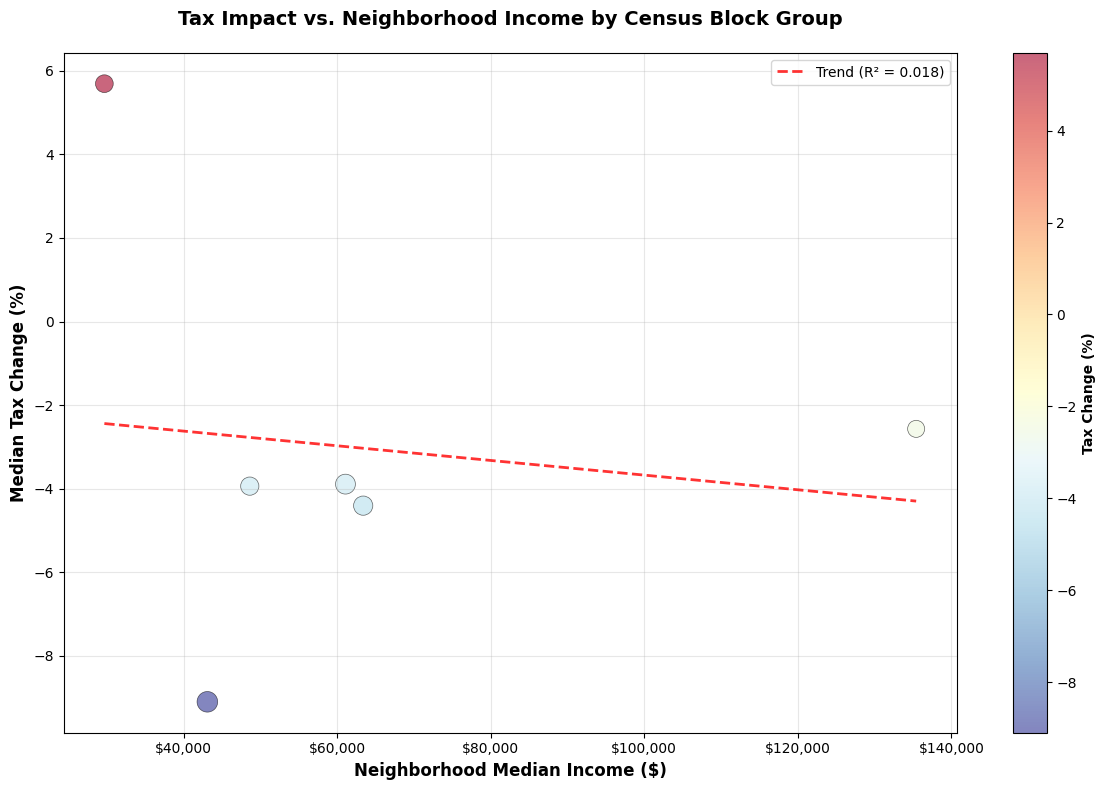

\n📊 Correlation Analysis:
- Correlation coefficient: -0.136
- R-squared: 0.018
- P-value: 7.979e-01
- Sample size: 6 observations
📉 Negative correlation: Higher income areas tend to have lower tax increases


In [47]:
# Scatter plot analysis: Income vs Tax Impact (similar to Spokane)
print("📈 Creating scatter plot analysis...")

if 'median_income' in df.columns and 'tax_change_pct' in df.columns:
    # Filter data for meaningful analysis
    plot_data = df[
        (df['median_income'].notna()) & 
        (df['median_income'] > 0) & 
        (df['tax_change_pct'].notna()) &
        (df['tax_change_pct'].abs() < 100)  # Remove extreme outliers
    ].copy()
    
    # Create block group level summary for cleaner visualization
    if 'census_block_group' in df.columns:
        block_summary = plot_data.groupby('census_block_group').agg({
            'median_income': 'first',  # Same for all parcels in block group
            'tax_change_pct': 'median',
            'tax_change': 'median',
            'current_tax': 'sum',
            'total_pop': 'first'
        }).reset_index()
        
        plot_data_agg = block_summary
        size_col = 'total_pop'
        title_suffix = "by Census Block Group"
    else:
        # Use individual parcels if no block group data
        plot_data_agg = plot_data.sample(min(1000, len(plot_data)))  # Sample for performance
        size_col = 'current_tax'
        title_suffix = "by Individual Parcels (Sample)"
    
    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create scatter plot with size based on population or tax
    scatter = ax.scatter(
        plot_data_agg['median_income'],
        plot_data_agg['tax_change_pct'],
        s=plot_data_agg[size_col] / plot_data_agg[size_col].max() * 200 + 20,
        alpha=0.6,
        c=plot_data_agg['tax_change_pct'],
        cmap='RdYlBu_r',
        edgecolors='black',
        linewidth=0.5
    )
    
    # Add trend line
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        plot_data_agg['median_income'], 
        plot_data_agg['tax_change_pct']
    )
    line_x = np.array([plot_data_agg['median_income'].min(), plot_data_agg['median_income'].max()])
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2, 
            label=f'Trend (R² = {r_value**2:.3f})')
    
    # Formatting
    ax.set_xlabel('Neighborhood Median Income ($)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Median Tax Change (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'Tax Impact vs. Neighborhood Income {title_suffix}', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Format x-axis as currency
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Tax Change (%)', fontweight='bold')
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation statistics
    correlation = plot_data_agg['median_income'].corr(plot_data_agg['tax_change_pct'])
    print(f"\\n📊 Correlation Analysis:")
    print(f"- Correlation coefficient: {correlation:.3f}")
    print(f"- R-squared: {r_value**2:.3f}")
    print(f"- P-value: {p_value:.3e}")
    print(f"- Sample size: {len(plot_data_agg):,} observations")
    
    if correlation > 0:
        print("📈 Positive correlation: Higher income areas tend to have higher tax increases")
    elif correlation < 0:
        print("📉 Negative correlation: Higher income areas tend to have lower tax increases")
    else:
        print("➡️  No clear correlation between income and tax changes")
        
else:
    print("❌ Required data not available for scatter plot analysis")


In [48]:
# Final Summary Analysis
print("📋 SYRACUSE LVT POLICY ANALYSIS SUMMARY")
print("=" * 60)

# Overall tax impact summary
total_parcels = len(df)
total_current_tax = df['current_tax'].sum()
total_tax_change = df['tax_change'].sum()
total_new_tax = total_current_tax + total_tax_change

print(f"\\n🏠 OVERALL IMPACT:")
print(f"- Total parcels analyzed: {total_parcels:,}")
print(f"- Current total tax revenue: ${total_current_tax:,.2f}")
print(f"- Total tax change: ${total_tax_change:,.2f}")
print(f"- New total tax revenue: ${total_new_tax:,.2f}")
print(f"- Net change: {(total_tax_change/total_current_tax)*100:+.2f}%")

# Winners and losers
tax_increases = (df['tax_change'] > 0).sum()
tax_decreases = (df['tax_change'] < 0).sum()
no_change = (df['tax_change'] == 0).sum()

print(f"\\n📊 DISTRIBUTION OF IMPACTS:")
print(f"- Properties with tax increases: {tax_increases:,} ({tax_increases/total_parcels*100:.1f}%)")
print(f"- Properties with tax decreases: {tax_decreases:,} ({tax_decreases/total_parcels*100:.1f}%)")
print(f"- Properties with no change: {no_change:,} ({no_change/total_parcels*100:.1f}%)")

# Median impacts
median_tax_change = df['tax_change'].median()
median_tax_change_pct = df['tax_change_pct'].median()

print(f"\\n📈 TYPICAL IMPACTS:")
print(f"- Median tax change: ${median_tax_change:.2f}")
print(f"- Median tax change percentage: {median_tax_change_pct:.2f}%")

# Census-based equity analysis (if available)
if 'median_income' in df.columns:
    print(f"\\n🏘️  EQUITY ANALYSIS:")
    
    # Low vs high income areas
    df_with_income = df[(df['median_income'].notna()) & (df['median_income'] > 0)]
    low_income_threshold = df_with_income['median_income'].quantile(0.33)
    high_income_threshold = df_with_income['median_income'].quantile(0.67)
    
    low_income_parcels = df_with_income[df_with_income['median_income'] <= low_income_threshold]
    high_income_parcels = df_with_income[df_with_income['median_income'] >= high_income_threshold]
    
    low_income_median_change = low_income_parcels['tax_change_pct'].median()
    high_income_median_change = high_income_parcels['tax_change_pct'].median()
    
    print(f"- Low-income areas (bottom 33%): {low_income_median_change:.2f}% median tax change")
    print(f"- High-income areas (top 33%): {high_income_median_change:.2f}% median tax change")
    
    if low_income_median_change < high_income_median_change:
        print("  → Policy appears progressive (lower burden on low-income areas)")
    elif low_income_median_change > high_income_median_change:
        print("  → Policy appears regressive (higher burden on low-income areas)")
    else:
        print("  → Policy appears neutral across income levels")

# Property type analysis summary
if category_col in df.columns:
    print(f"\\n🏢 PROPERTY TYPE IMPACTS:")
    
    # Find the categories with biggest increases and decreases
    cat_summary = df.groupby(category_col)['tax_change'].agg(['sum', 'median', 'count']).round(2)
    cat_summary = cat_summary.sort_values('sum', ascending=False)
    
    print("Top 3 categories by total tax increase:")
    for i, (cat, row) in enumerate(cat_summary.head(3).iterrows()):
        print(f"  {i+1}. {cat}: ${row['sum']:,.0f} total, ${row['median']:.0f} median ({row['count']:,} properties)")
    
    print("\\nTop 3 categories by total tax decrease:")
    for i, (cat, row) in enumerate(cat_summary.tail(3).iterrows()):
        print(f"  {i+1}. {cat}: ${row['sum']:,.0f} total, ${row['median']:.0f} median ({row['count']:,} properties)")

print(f"\\n" + "=" * 60)
print("📝 NOTES:")
print("- This analysis uses sample/placeholder tax change data for demonstration")
print("- Replace the tax change calculations with your actual LVT policy model")
print("- Census data integration provides demographic context for equity analysis")
print("- Visualizations above show the distributional impacts across income and property types")

print(f"\\n✅ Analysis complete! Review the visualizations above for detailed insights.")


📋 SYRACUSE LVT POLICY ANALYSIS SUMMARY
\n🏠 OVERALL IMPACT:
- Total parcels analyzed: 64,762
- Current total tax revenue: $300,069,056.03
- Total tax change: $1,843,383.32
- New total tax revenue: $301,912,439.34
- Net change: +0.61%
\n📊 DISTRIBUTION OF IMPACTS:
- Properties with tax increases: 30,615 (47.3%)
- Properties with tax decreases: 34,095 (52.6%)
- Properties with no change: 52 (0.1%)
\n📈 TYPICAL IMPACTS:
- Median tax change: $-26.75
- Median tax change percentage: -1.26%
\n🏘️  EQUITY ANALYSIS:
- Low-income areas (bottom 33%): 6.10% median tax change
- High-income areas (top 33%): -8.73% median tax change
  → Policy appears regressive (higher burden on low-income areas)


NameError: name 'category_col' is not defined